In [1]:
import xml.etree.ElementTree as ET
import os
import json

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split, KFold

In [2]:
df = pd.read_csv('../input/train.csv')
df

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1
...,...,...,...,...,...
147788,5e0747034,1024,1024,"[64.0, 619.0, 84.0, 95.0]",arvalis_2
147789,5e0747034,1024,1024,"[292.0, 549.0, 107.0, 82.0]",arvalis_2
147790,5e0747034,1024,1024,"[134.0, 228.0, 141.0, 71.0]",arvalis_2
147791,5e0747034,1024,1024,"[430.0, 13.0, 184.0, 79.0]",arvalis_2


In [3]:
# split bbox column
bbox_items = df.bbox.str.split(',', expand=True)
df['bbox_xmin'] = bbox_items[0].str.strip('[ ').astype(float)
df['bbox_ymin'] = bbox_items[1].str.strip(' ').astype(float)
df['bbox_width'] = bbox_items[2].str.strip(' ').astype(float)
df['bbox_height'] = bbox_items[3].str.strip(' ]').astype(float)

In [5]:
df['aspect_ratio'] = df['bbox_height'] / df['bbox_width']

In [11]:
df['aspect_ratio'].describe()

count    147793.000000
mean          1.045684
std           1.082033
min           0.007843
25%           0.663462
50%           0.913043
75%           1.225806
max         191.000000
Name: aspect_ratio, dtype: float64

In [16]:
ar = df['aspect_ratio'].values
ar = ar[ar<4]

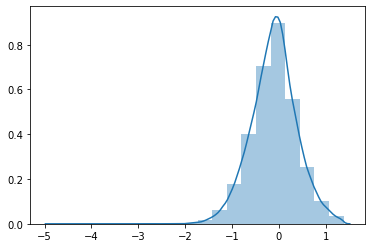

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(np.log(ar), bins=20)
plt.show()

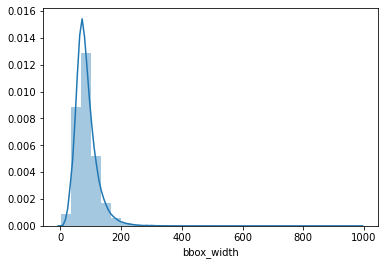

In [22]:
sns.distplot(df['bbox_width'], bins=30)
plt.show()

In [49]:
(df['aspect_ratio'] < 1/4).mean()

0.007266920625469407

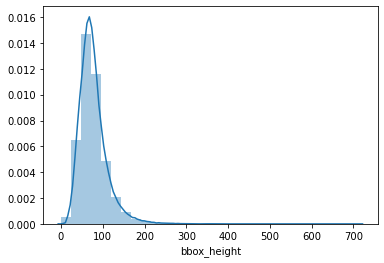

In [21]:
sns.distplot(df['bbox_height'], bins=30)
plt.show()

In [3]:
with open('instances_val2017.json', 'r') as f:
    j = json.load(f)

In [4]:
j.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [5]:
j['info']

{'description': 'COCO 2017 Dataset',
 'url': 'http://cocodataset.org',
 'version': '1.0',
 'year': 2017,
 'contributor': 'COCO Consortium',
 'date_created': '2017/09/01'}

In [6]:
j['images'][0]

{'license': 4,
 'file_name': '000000397133.jpg',
 'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg',
 'height': 427,
 'width': 640,
 'date_captured': '2013-11-14 17:02:52',
 'flickr_url': 'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg',
 'id': 397133}

In [7]:
j['annotations'][50]

{'segmentation': [[388.52,
   2.8,
   567.17,
   15.71,
   574.71,
   234.19,
   575.78,
   379.48,
   572.56,
   467.73,
   574.71,
   473.11,
   319.64,
   467.73,
   1.08,
   473.11,
   3.23,
   310.6,
   1.08,
   130.87,
   2.15,
   3.87,
   189.42,
   1.72]],
 'area': 265862.40795,
 'iscrowd': 0,
 'image_id': 433915,
 'bbox': [1.08, 1.72, 574.7, 471.39],
 'category_id': 72,
 'id': 29555}

In [8]:
j['categories'][0]

{'supercategory': 'person', 'id': 1, 'name': 'person'}

In [9]:
def addAnnoItem(image_id, category_id, bbox, annotation_id):
    annotation_item = dict()
    annotation_item['segmentation'] = []
    seg = []
    # bbox[] is x,y,w,h
    # left_top
    seg.append(bbox[0])
    seg.append(bbox[1])
    # left_bottom
    seg.append(bbox[0])
    seg.append(bbox[1] + bbox[3])
    # right_bottom
    seg.append(bbox[0] + bbox[2])
    seg.append(bbox[1] + bbox[3])
    # right_top
    seg.append(bbox[0] + bbox[2])
    seg.append(bbox[1])
 
    annotation_item['segmentation'].append(seg)
 
    annotation_item['area'] = bbox[2] * bbox[3]
    annotation_item['iscrowd'] = 0
    annotation_item['image_id'] = image_id
    annotation_item['bbox'] = bbox
    annotation_item['category_id'] = category_id
    annotation_item['id'] = annotation_id
    
    return annotation_item

In [10]:
coco = dict()
coco['images'] = []
coco['annotations'] = []
coco['categories'] = []
 
category_set = dict()
image_set = set()
 
category_item_id = -1
image_id = 20200000000
annotation_id = 0

In [11]:
df_grouped = df.groupby('image_id')

In [12]:
for file_name, sub_df in tqdm(df_grouped):
    coco['images'].append({
        'file_name': file_name + '.jpg',
        'height': sub_df['height'].tolist()[0],
        'width': sub_df['width'].tolist()[0],
        'id': image_id
    })
    for bbox in np.array(sub_df['bbox']):
        coco['annotations'].append(addAnnoItem(image_id, 0, eval(bbox), annotation_id))
        annotation_id += 1
    image_id += 1
coco['categories'].append({
    'supercategory': 'wheat', 'id': 1, 'name': 'wheat'
})

[{'supercategory': 'wheat', 'id': 1, 'name': 'wheat'}]

In [18]:
image_ids = np.array([j['id'] for j in coco['images']])

In [19]:
kf = KFold(n_splits=5)
for fold, (train_index, valid_index) in enumerate(kf.split(image_ids)):
    train_ids, valid_ids = image_ids[train_index], image_ids[valid_index]
    
    fold_train_coco = coco.copy()
    fold_train_coco['images'] = [j for j in coco['images'] if j['id'] in train_ids]
    fold_train_coco['annotations'] = [j for j in coco['annotations'] if j['image_id'] in train_ids]
    
    fold_valid_coco = coco.copy()
    fold_valid_coco['images'] = [j for j in coco['images'] if j['id'] in valid_ids]
    fold_valid_coco['annotations'] = [j for j in coco['annotations'] if j['image_id'] in valid_ids]
    
    with open('fold{}_train.json'.format(fold), 'w') as f:
        json.dump(fold_train_coco, f)

    with open('fold{}_valid.json'.format(fold), 'w') as f:
        json.dump(fold_valid_coco, f)